In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [3]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices

    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]

    # Pivot as before
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the original selection order
    pivoted = pivoted.loc[selected_cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = [3, 13, 15, 81, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
list_cell_lines = [3, 13, 81, 25, 54, 74, 97, 40]
list_cell_lines = [3, 13, 81]
list_cell_lines = [3, 29, 81]
# list_cell_lines = [3, 29, 81, 25, 54, 74, 97, 40]
# list_cell_lines = range(64)
# list_cell_lines = [11, 81, 32]
x, Y = preprocess_data(df, list_cell_lines)

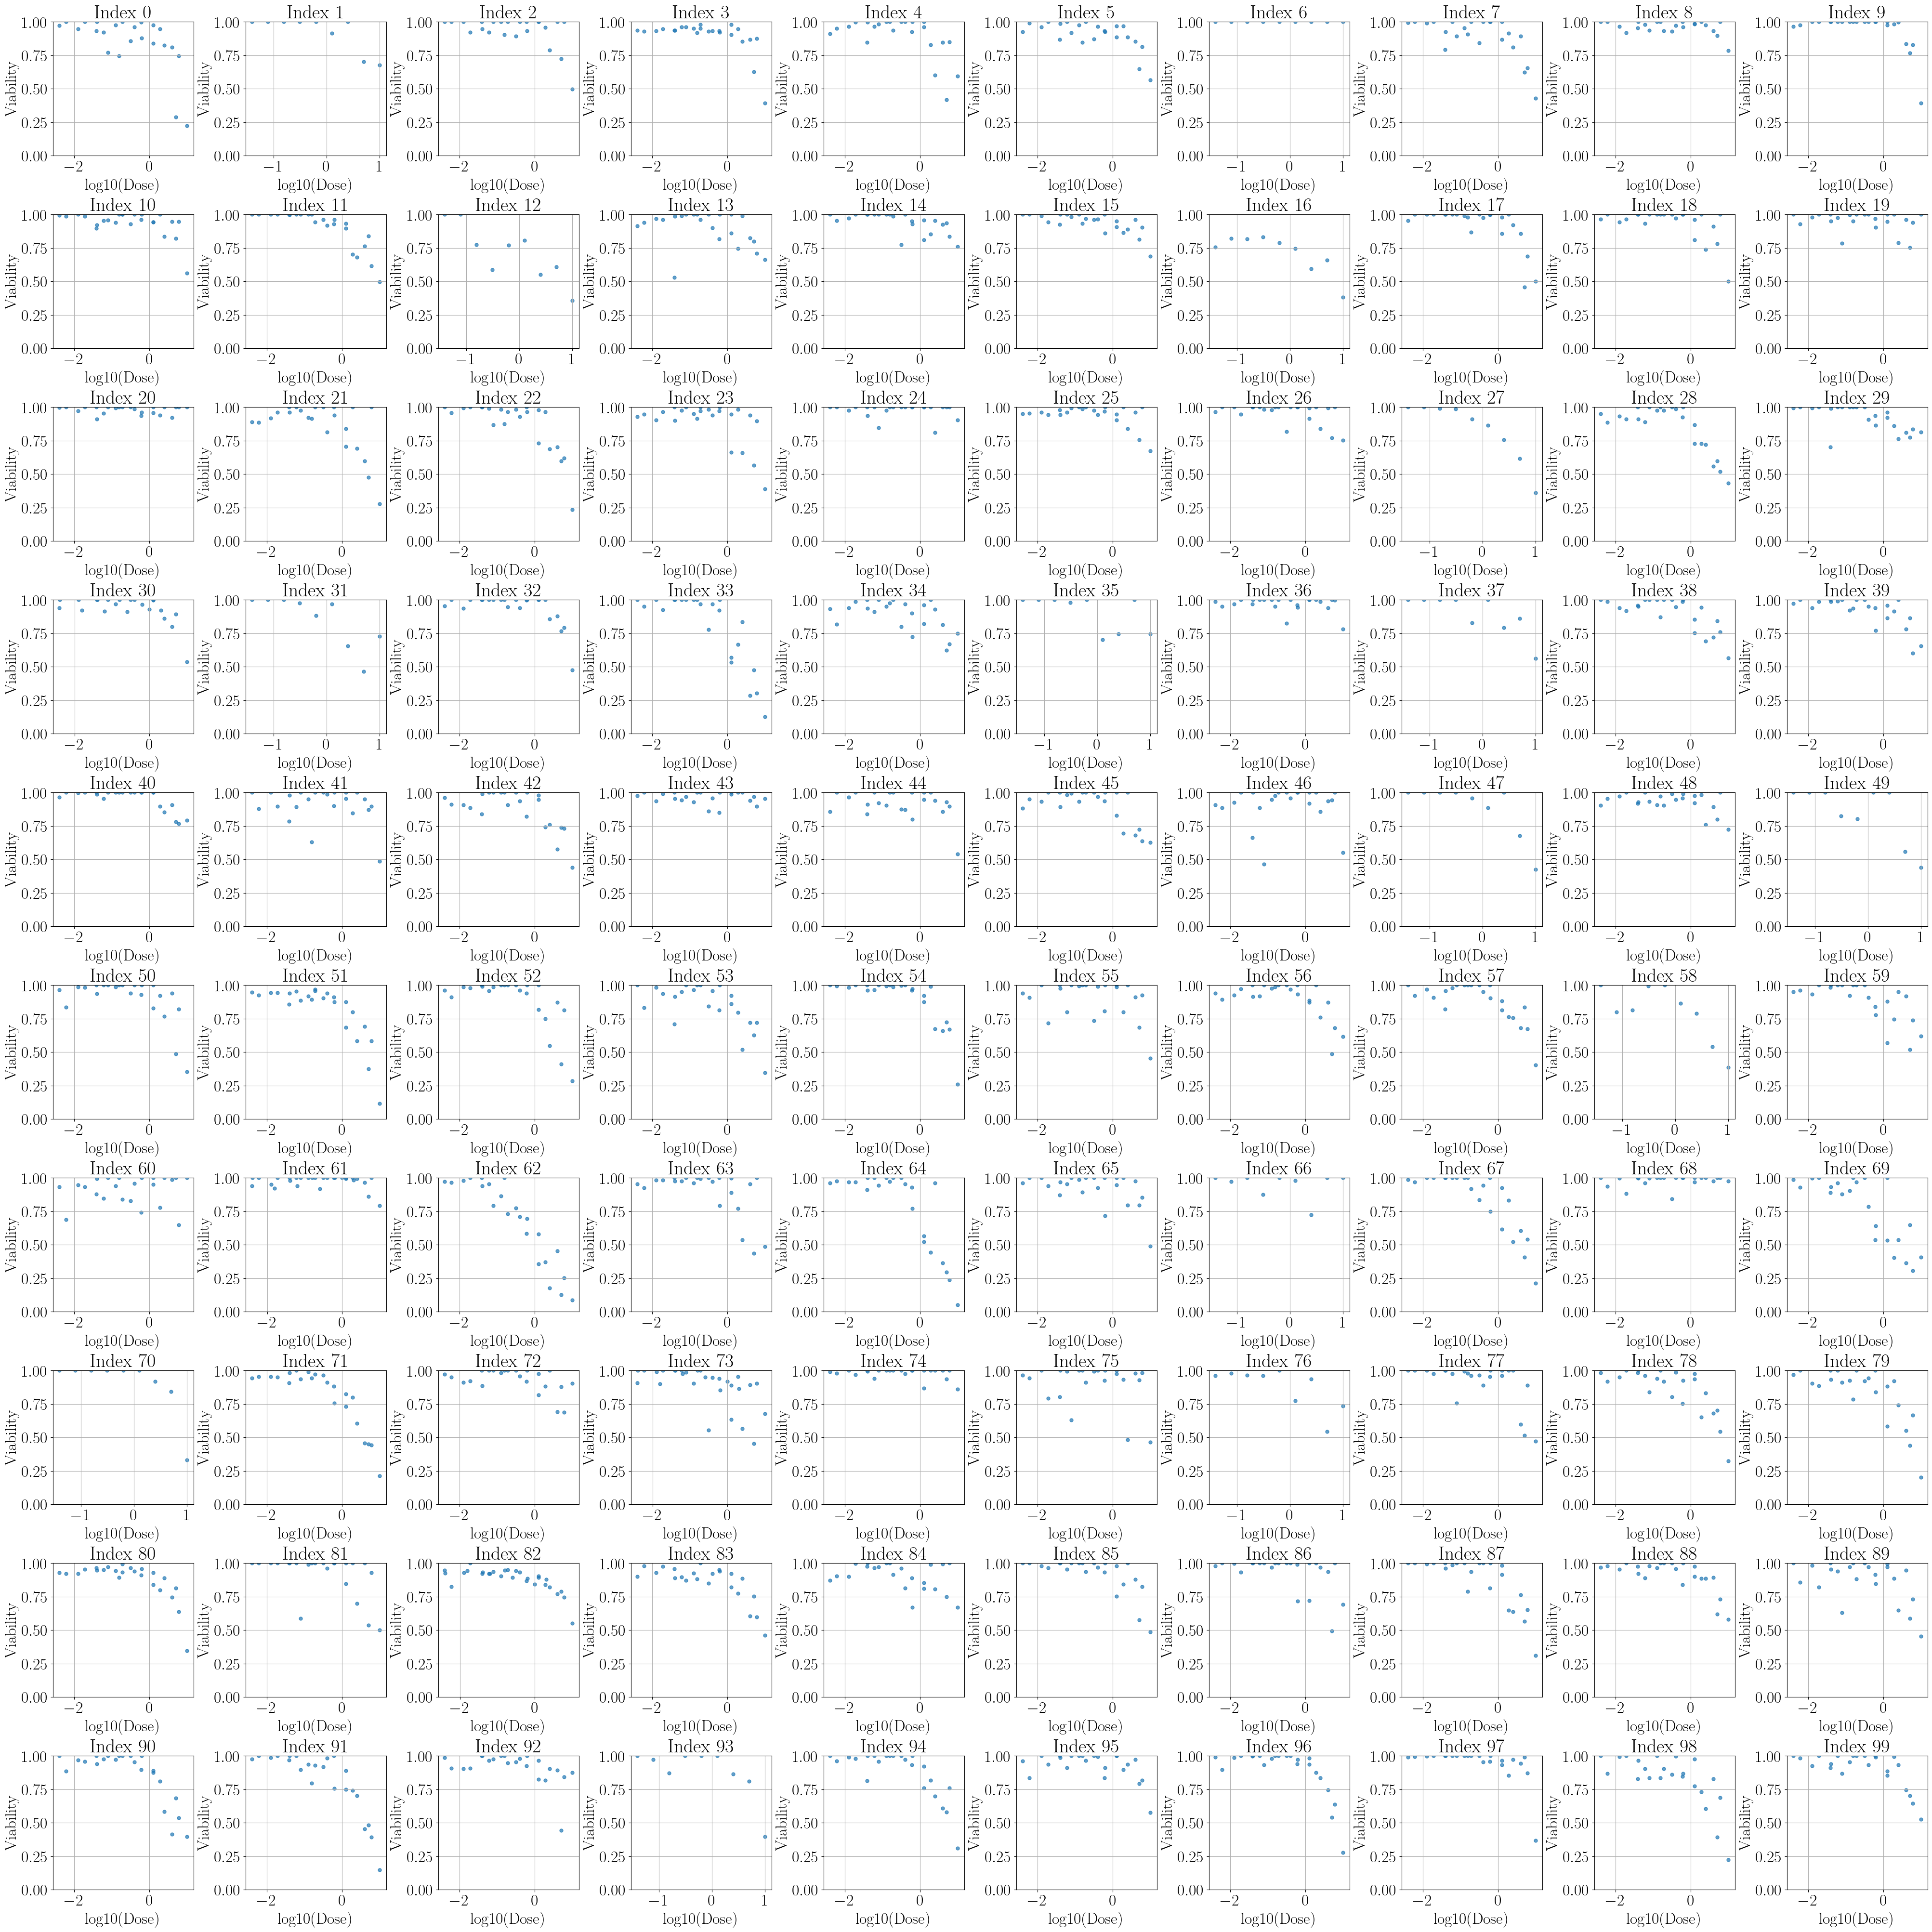

In [18]:
def visual_examples(df, k):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 100)

In [4]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

## MOGP

Optimized length_scale: 1.6803
Optimized noise: [0.00609279 0.00597961 0.01635062]
Optimized A: [[0.26849949 0.22554322 0.13040216]
 [0.27888525 0.23426072 0.13544262]
 [0.28178506 0.23669893 0.1368534 ]]
Optimized B: 
[[0.13996644 0.14537847 0.14689096]
 [0.14537847 0.15099977 0.15257074]
 [0.14689096 0.15257074 0.15415805]]


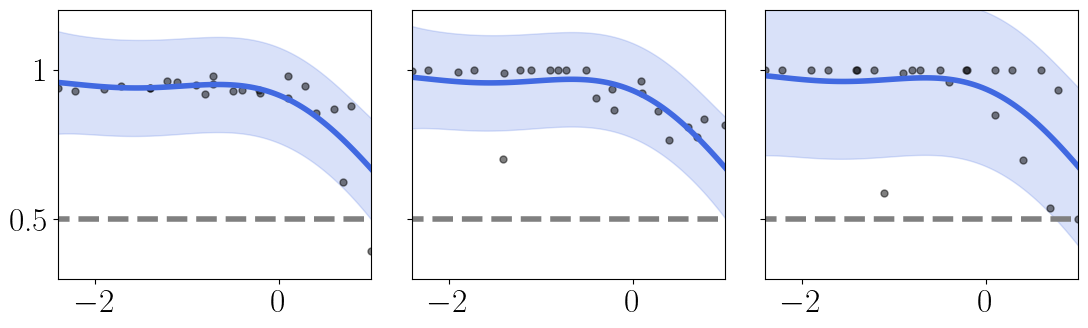

In [5]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1, 0.1, 0.1]) 
init_A = generate_A(d=n_outputs, r=3, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

## MORCGP

Optimized length_scale: 3.7422, noise: 0.002794
Optimized A: [[0.90599835 0.7658595  0.44213534]
 [0.98874298 0.83565343 0.48250707]
 [1.0106069  0.85418872 0.49320753]]
Optimized B: 
[[1.60285745 1.74912606 1.78786121]
 [1.74912606 1.90874241 1.95101233]
 [1.78786121 1.95101233 1.99421834]]


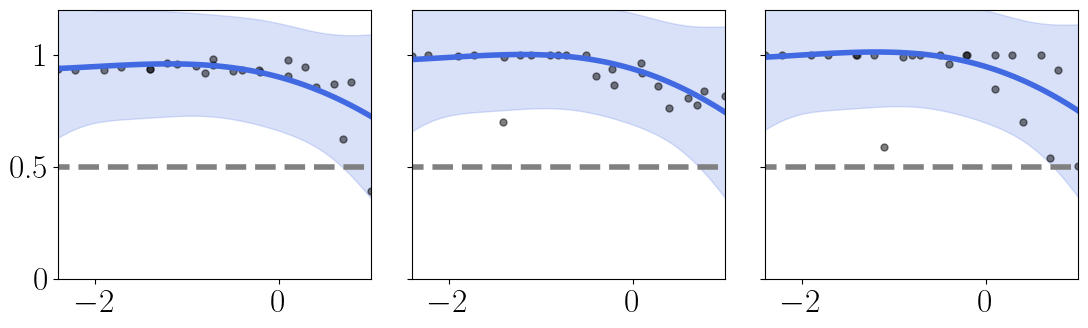

In [10]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
morcgp = MORCGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = optim_noise, A=optim_A)
morcgp = MORCGPRegressor_NC(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = optim_noise[0].item(), A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y)

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, B_weighted=optim_B)
predictive_means, predictive_variances = morcgp.fit(x, Y)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

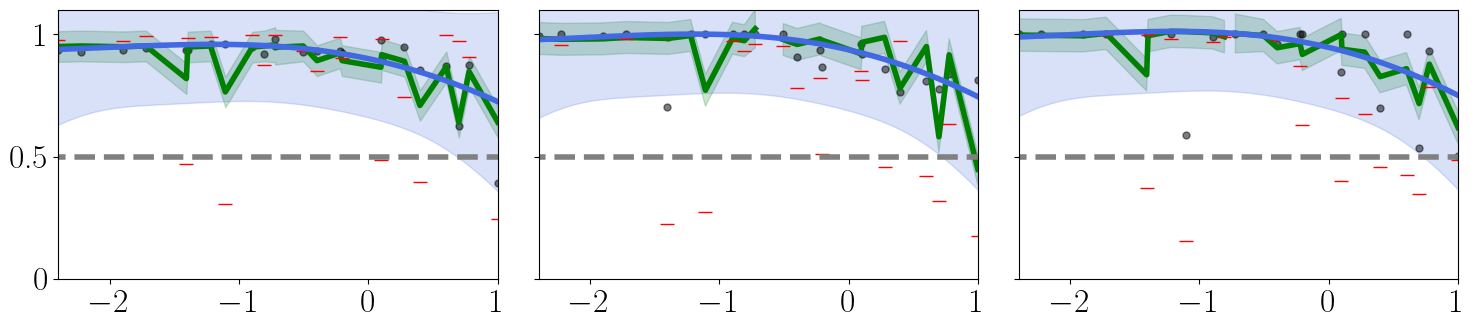

In [11]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(4 * 4, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='green', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + np.sqrt(predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), ((morcgp.w.reshape(n_outputs,-1).T/(morcgp.noise/2)**0.5))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.9, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

In [ ]:
print(Y.shape)

(24, 3)


In [10]:
print((1+(Y.flatten(order='F') - predictive_means.flatten(order='F'))**2/predictive_variances.flatten(order='F'))**-0.5)

[0.98021418 0.75951451 0.98966388 0.92810769 0.03645199 0.85687911
 0.49461125 0.14029585 0.88080914 0.48208168 0.47938014 0.68135087
 0.69972639 0.14016609 0.18373377 0.09094877 0.27909499 0.22038458
 0.07419221 0.11627225 0.083713   0.06836255 0.1166304  0.02640057
 0.99364577 0.72300432 0.99834501 0.95518056 0.03604954 0.8876152
 0.512753   0.13330805 0.91485101 0.46147634 0.48371479        nan
 0.66566113 0.1401939  0.18410513 0.0903143  0.28927995 0.22063264
 0.07366157 0.11673955 0.08283421 0.0670745  0.1160275  0.02607243
 0.99675734 0.68105564 0.99185926 0.99575125 0.03860922 0.95755873
 0.59481148 0.13082745 0.98036924 0.45312906        nan 0.70020314
 0.631479   0.15374711 0.20237397 0.09753204 0.3440499  0.2415576
 0.07955023 0.12938636 0.0887391  0.07056149 0.1257539  0.02784509]


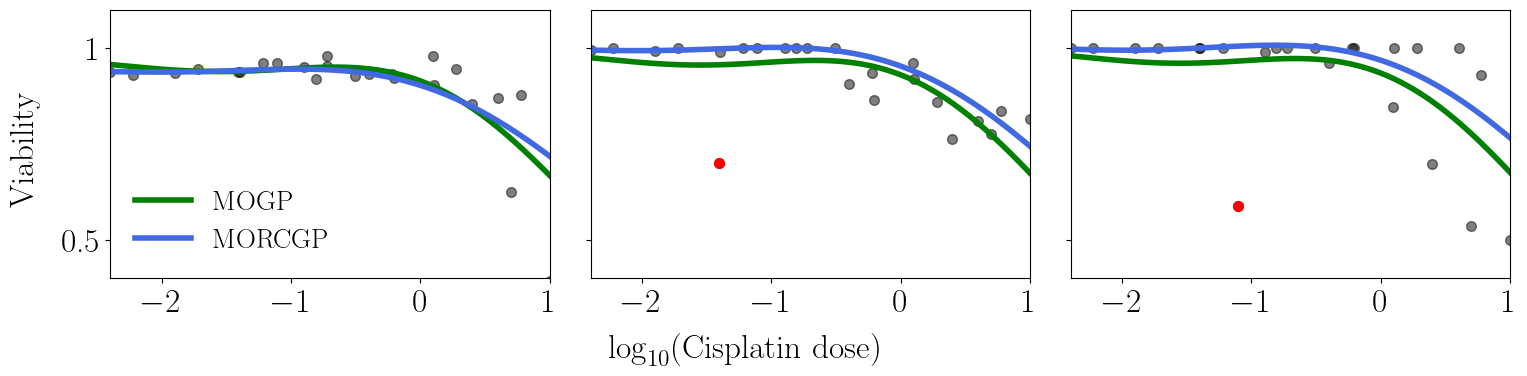

In [9]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5, markersize=7)
    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    axs[i].set_ylim([0.4, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
        legend = axs[i].legend(loc='lower left', frameon=True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('white')
        frame.set_alpha(1.0)  # Fully opaque
    else:
        axs[i].set_yticklabels([])  # Hide on all others

axs[1].plot(x.flatten()[4], Y[4, 1], 'o', color='red', markersize=7)
axs[2].plot(x.flatten()[7], Y[7, 2], 'o', color='red', markersize=7)

# Common axis labels
fig.text(0.5, 0.04, r'$\log_{10}(\textrm{Cisplatin dose})$', ha='center', fontsize=24)
fig.text(0.04, 0.56, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

# fig.savefig("./cisplatin_MOGP.pdf", format='pdf', bbox_inches='tight')

## Test

[ 1.24518493  1.21218672  1.22609164  1.27398896  0.99886156  1.19727367
  1.33113225  0.75206433  1.2959193   1.08577653  1.36965143  1.33717545
  1.24746569  1.31762519  1.38138268  1.35621077  0.90895057  1.36595592
  0.99143366  0.9501243   1.07435102  0.07650264  0.42112948 -0.3787868
  1.25852261  1.28126843  1.3365428   1.33618446 -0.35525763  1.33422074
  1.35190323  0.60747425  1.33571804  1.31119972  1.35958068  1.31570586
  1.07832027  1.3351317   0.86544242  1.17077713  1.36385647  1.09620844
  0.91744582  1.04601443  0.7354304   1.03488687  0.16214922  1.25924193
  1.30671249  1.33053776  1.34882797  0.79445259  1.32743338  1.35506299
 -0.65632794  1.34940431  1.32870393  1.31458894  1.34125321  1.30539908
  1.20193971  1.05791818  0.90161411  0.9251313   0.68535086  0.30126878
  0.17805284 -0.34473227 -0.01486317 -0.52424635]
[ 1.24518493  1.21218672  1.22609164  1.27398896  0.99886156  1.19727367
  1.33113225  0.75206433  1.2959193   1.08577653  1.36965143  1.33717545
  

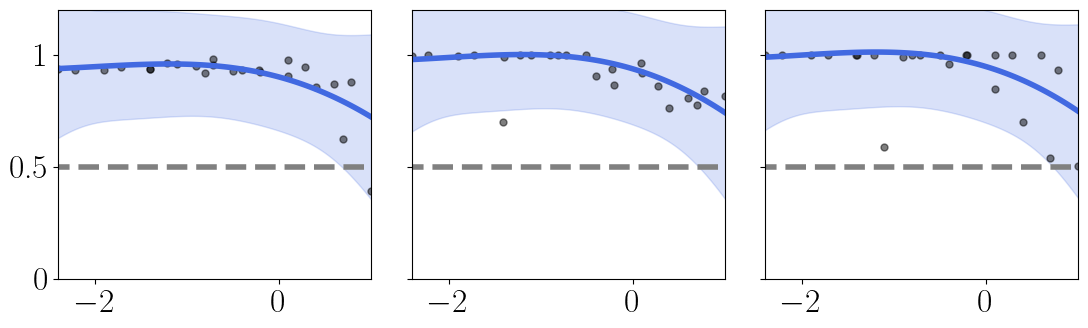

In [8]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = 0.004898
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
morcgp = MORCGPRegressor_deprecated(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = optim_noise.item(), A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y)

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, B_weighted=optim_B)

predictive_means, predictive_variances = morcgp.fit(x, Y)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

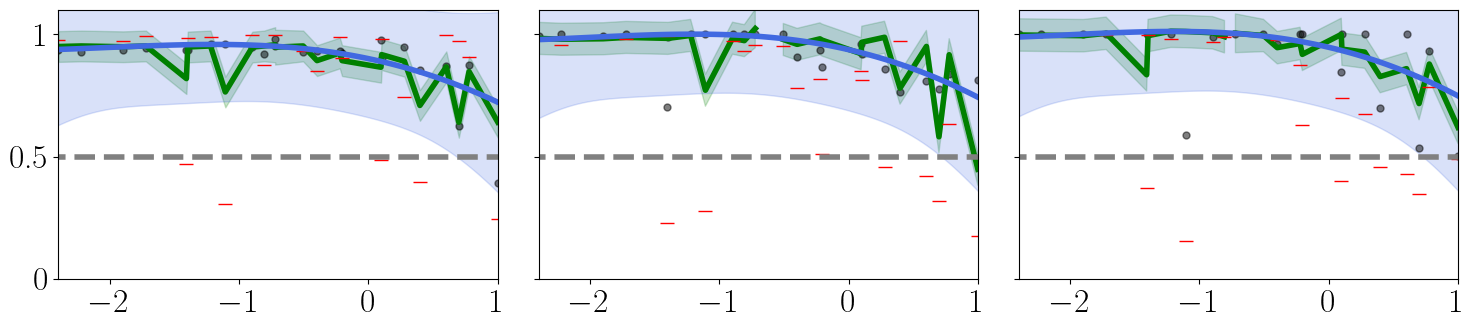

In [8]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(4 * 4, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='green', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + np.sqrt(predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), ((morcgp.w.reshape(n_outputs,-1).T/(morcgp.noise/2)**0.5))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.9, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()